In [1]:
import jax
from flax import nnx

In [2]:
# Import additional libraries for data loading and training
from datasets import load_dataset, Dataset
import numpy as np
import optax
from tqdm import tqdm
from typing import Optional, Callable

/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.devices()

W1214 12:04:20.850225    7478 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1214 12:04:20.852210    7265 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


[CudaDevice(id=0)]

In [4]:
data_dir = "./data"
# Load CIFAR-10 dataset
dataset = load_dataset("uoft-cs/cifar10", cache_dir=data_dir)
dataset = dataset.with_format("jax")
train_data = dataset["train"]
test_data = dataset["test"]
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

print(train_data.features)

print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Sample shape: {train_data[0]['img'].shape}")

data_dim = train_data[0]["img"].shape[0] * train_data[0]["img"].shape[1] * train_data[0]["img"].shape[2]


{'img': Image(mode=None, decode=True), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}
Train samples: 50000
Test samples: 10000
Sample shape: (32, 32, 3)


In [5]:
# Training configuration
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
SAVE_EVERY_N_EPOCHS = 1

In [6]:
from typing import TypedDict
import grain.python as grain
import jax.numpy as jnp


seed = 12
val_batch_size = 2 * BATCH_SIZE


def preprocess(image: jnp.ndarray, *, rng: Optional[np.random.Generator] = None) -> jnp.ndarray:
    # Convert to float32 and normalize to [0, 1]
    image = jnp.array(image, dtype=jnp.float32) / 255.0
    # Flatten the image
    return image
    
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

train_grain_dataset = grain.MapDataset.source(train_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng = rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=BATCH_SIZE)

test_grain_dataset = grain.MapDataset.source(test_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng = rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=val_batch_size)

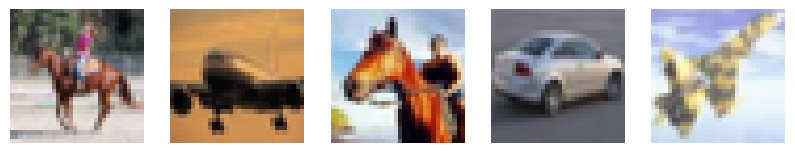

In [7]:
# Display 5 samples from the training dataset
import matplotlib.pyplot as plt

example_batch = next(iter(train_grain_dataset))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(example_batch[i].reshape(32, 32, 3))
    axes[i].axis('off')
plt.show()

In [8]:
from typing import Literal


def get_norm_layer(norm_type: Literal["BN", "LN", "GN"], num_features: int, rngs: nnx.Rngs) -> Callable[[jax.Array], jax.Array]:
    """Normalization layer."""
    if norm_type == 'BN':
        raise NotImplementedError
    elif norm_type == 'LN':
        norm_fn = nnx.LayerNorm(num_features=num_features, rngs=rngs)
    elif norm_type == 'GN':
        norm_fn = nnx.GroupNorm(num_features=num_features, rngs=rngs)
    else:
        raise NotImplementedError
    return norm_fn


def tensorflow_style_avg_pooling(x: jax.Array, window_shape: tuple[int, int], strides: tuple[int, int], padding: str) -> jax.Array:
    pool_sum = jax.lax.reduce_window(x, 0.0, jax.lax.add,
                                   (1,) + window_shape + (1,),
                                   (1,) + strides + (1,), padding)
    pool_denom = jax.lax.reduce_window(
        jnp.ones_like(x), 0.0, jax.lax.add, (1,) + window_shape + (1,),
        (1,) + strides + (1,), padding)
    return pool_sum / pool_denom

def upsample_2d(x: jax.Array, factor: int = 2) -> jax.Array:
    n, h, w, c = x.shape
    x = jax.image.resize(x, (n, h * factor, w * factor, c), method='nearest')
    return x

def downsample_2d(x: jax.Array) -> jax.Array:
    return tensorflow_style_avg_pooling(x, (2, 2), strides=(2, 2), padding='same')

def squared_euclidean_distance(a: jax.Array,
                               b: jax.Array,
                               b2: Optional[jax.Array] = None) -> jax.Array:
    """Computes the pairwise squared Euclidean distance.

    Args:
        a: float32: (n, d): An array of points.
        b: float32: (m, d): An array of points.
        b2: float32: (d, m): b square transpose.

    Returns:
        d: float32: (n, m): Where d[i, j] is the squared Euclidean distance between
        a[i] and b[j].
    """
    if b2 is None:
        b2 = jnp.sum(b.T**2, axis=0, keepdims=True)
    a2 = jnp.sum(a**2, axis=1, keepdims=True)
    ab = jnp.matmul(a, b.T)
    d = a2 - 2 * ab + b2
    return d

sed = squared_euclidean_distance

def entropy_loss_fn(affinity: jax.Array, loss_type: Literal["softmax", "argmax"] = "softmax", temperature: float = 1.0):
    """Calculates the entropy loss. Affinity is the similarity/distance matrix."""
    flat_affinity = affinity.reshape(-1, affinity.shape[-1])
    flat_affinity /= temperature
    probs = jax.nn.softmax(flat_affinity, axis=-1)
    log_probs = jax.nn.log_softmax(flat_affinity + 1e-5, axis=-1)
    if loss_type == "softmax":
        target_probs = probs
    elif loss_type == "argmax":
        codes = jnp.argmax(flat_affinity, axis=-1)
        onehots = jax.nn.one_hot(
            codes, flat_affinity.shape[-1], dtype=flat_affinity.dtype)
        onehots = probs - jax.lax.stop_gradient(probs - onehots)
        target_probs = onehots
    else:
        raise ValueError("Entropy loss {} not supported".format(loss_type))
    avg_probs = jnp.mean(target_probs, axis=0)
    avg_entropy = -jnp.sum(avg_probs * jnp.log(avg_probs + 1e-5))
    sample_entropy = -jnp.mean(jnp.sum(target_probs * log_probs, axis=-1))
    loss = sample_entropy - avg_entropy
    return loss

def sg(x: jax.Array) -> jax.Array:
    return jax.lax.stop_gradient(x)


In [9]:
class ResBlock(nnx.Module):
    """Basic Residual Block."""
    norm_1: Callable[[jax.Array], jax.Array]
    activation_fn1: Callable[[jax.Array], jax.Array]
    conv_1: nnx.Conv
    norm_2: Callable[[jax.Array], jax.Array]
    activation_fn2: Callable[[jax.Array], jax.Array]
    conv_2: nnx.Conv
    residual_conv: nnx.Conv
    in_features: int
    out_features: int

    
    def __init__(self, in_features: int, out_features: int, norm_type: Literal['BN', 'LN', 'GN'], activation_fn: Callable[[jax.Array], jax.Array], rngs: nnx.Rngs):
        self.in_features = in_features
        self.out_features = out_features
        self.norm_1 = get_norm_layer(norm_type, in_features, rngs)
        self.activation_fn1 = activation_fn
        self.conv_1 = nnx.Conv(in_features, kernel_size=(3, 3), use_bias=False, out_features=out_features, rngs=rngs)
        self.norm_2 = get_norm_layer(norm_type, out_features, rngs)
        self.activation_fn2 = activation_fn
        self.conv_2 = nnx.Conv(out_features, kernel_size=(3, 3), use_bias=False, out_features=out_features, rngs=rngs)
        self.residual_conv = nnx.Conv(in_features, kernel_size=(1, 1), use_bias=False, out_features=out_features, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        input_dim = x.shape[-1]
        residual = x
        x= self.norm_1(x)
        x= self.activation_fn1(x)
        x= self.conv_1(x)
        x= self.norm_2(x)
        x= self.activation_fn2(x)
        x= self.conv_2(x)

        if input_dim != x.shape[-1]:
            residual = self.residual_conv(residual)
        
        return x + residual
    
def multi_resblock(num_blocks: int, in_features: int, out_features: int, norm_type: Literal['BN', 'LN', 'GN'], activation_fn: Callable[[jax.Array], jax.Array], rngs: nnx.Rngs) -> nnx.Sequential:
    return nnx.Sequential(*[
        ResBlock(
            in_features=in_features if i == 0 else out_features,
            out_features=out_features,
            norm_type=norm_type,
            activation_fn=activation_fn,
            rngs=rngs)
        for i in range(num_blocks)
    ])

class Encoder(nnx.Module):
    """From [H,W,D] image to [H',W',D'] embedding. Using Conv layers."""

    norm_layer: Callable[[jax.Array], jax.Array]
    initial_conv: nnx.Conv
    activation_fn: Callable[[jax.Array], jax.Array]
    blocks: nnx.Sequential
    final_res_blocks: nnx.Sequential
    last_conv: nnx.Conv

    def __init__(self, filters: int, num_res_blocks: int, channel_multipliers: list[int], embedding_dim: int, norm_type: Literal['BN', 'LN', 'GN'], quantizer_type: str, image_channels: int, rngs: nnx.Rngs, activation_fn: Callable[[jax.Array], jax.Array] = nnx.swish):
        self.norm_layer = get_norm_layer(norm_type, filters * channel_multipliers[-1], rngs)
        self.activation_fn = activation_fn

        self.initial_conv = nnx.Conv(kernel_size=(3, 3), use_bias=False, in_features=image_channels, out_features=filters, rngs=rngs)

        self.blocks = nnx.Sequential(*[
            nnx.Sequential(
                multi_resblock(
                    num_blocks=num_res_blocks,
                    in_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                    out_features=filters * channel_multipliers[i],
                    norm_type=norm_type,
                    activation_fn=activation_fn,
                    rngs=rngs),
                # Add downsample layer if not the last block
                *([] if i == len(channel_multipliers) - 1 else [lambda x: downsample_2d(x)])
            )
            for i in range(len(channel_multipliers))
        ])

        # Then add the final res blocks
        self.final_res_blocks = multi_resblock(
            num_blocks=num_res_blocks,
                in_features=filters * channel_multipliers[-1],
                out_features=filters * channel_multipliers[-1],
                norm_type=norm_type,
                activation_fn=activation_fn,
                rngs=rngs)
        
        last_dim = embedding_dim*2 if quantizer_type == 'kl' else embedding_dim
        self.last_conv = nnx.Conv(
            in_features=filters * channel_multipliers[-1],
            out_features=last_dim,
            kernel_size=(1, 1),
            use_bias=False,
            rngs=rngs)
        

    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.blocks(x)

        x = self.final_res_blocks(x)
        x = self.norm_layer(x)
        x = self.activation_fn(x)

        x = self.last_conv(x)

        return x
    
class Decoder(nnx.Module):
    """From [H',W',D'] embedding to [H,W,D] embedding. Using Conv layers."""

    def __init__(self, embedding_dim: int, filters: int, num_res_blocks: int, channel_multipliers: list[int], image_channels: int, norm_type: Literal['BN', 'LN', 'GN'], rngs: nnx.Rngs, activation_fn: Callable[[jax.Array], jax.Array] = nnx.swish):
        self.norm_layer = get_norm_layer(norm_type, filters, rngs)
        self.activation_fn = activation_fn
        self.initial_conv = nnx.Conv(in_features=embedding_dim, kernel_size=(3, 3), use_bias=True, out_features=filters * channel_multipliers[-1], rngs=rngs)


        self.initial_res_blocks = multi_resblock(
            num_blocks=num_res_blocks,
                in_features=filters * channel_multipliers[-1],
                out_features=filters * channel_multipliers[-1],
                norm_type=norm_type,
                activation_fn=activation_fn,
                rngs=rngs)

        # Decoder blocks with upsampling
        self.decoder_blocks = nnx.Sequential(*[
            nnx.Sequential(
                multi_resblock(
                    num_blocks=num_res_blocks,
                    in_features=filters * channel_multipliers[i],
                    out_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                    norm_type=norm_type,
                    activation_fn=activation_fn,
                    rngs=rngs)
                ,
                # Add upsample_2d + conv if not the first block (i > 0)
                *([] if i == 0 else [
                    lambda x: upsample_2d(x, 2),
                    nnx.Conv(
                        in_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                        out_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                        kernel_size=(3, 3),
                        rngs=rngs)
                ])
            )
            for i in reversed(range(len(channel_multipliers)))
        ])
        self.final_conv = nnx.Conv(in_features=filters, out_features=image_channels, kernel_size=(3, 3), rngs=rngs)

    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.initial_res_blocks(x)
        x = self.decoder_blocks(x)
        x = self.norm_layer(x)
        x = self.activation_fn(x)
        x = self.final_conv(x)
        
        return x

In [10]:
from abc import ABC, abstractmethod


from typing import TypeVar, Generic

T = TypeVar('T')

class Quantizer(ABC, Generic[T]):

    @abstractmethod
    def __call__(self, x: jax.Array) -> tuple[jax.Array, T]:
        pass

    @abstractmethod
    def encode_to_idx(self, x: jax.Array) -> jax.Array:
        pass

    @abstractmethod
    def decode_from_idx(self, ids: jax.Array) -> jax.Array:
        pass

In [11]:
from typing import Literal
from flax import nnx
import jax.numpy as jnp
import jax
 
class VectorQuantizerCodebook(nnx.Param[jax.Array]): pass

class VectorQuantizerResults(TypedDict):
    quantizer_loss: jax.Array
    e_latent_loss: jax.Array
    q_latent_loss: jax.Array
    entropy_loss: jax.Array
    z_ids: jax.Array

class VectorQuantizer(nnx.Module, Quantizer[VectorQuantizerResults]):
    """Basic vector quantizer."""
    deterministic: bool = False
    codebook: VectorQuantizerCodebook
    commitment_cost: float
    entropy_loss_type: Literal["softmax", "argmax"]
    entropy_loss_ratio: float
    entropy_temperature: float

    def __init__(self, codebook_size: int, embedding_dim: int, commitment_cost: float, entropy_loss_type: Literal['softmax', 'argmax'], entropy_loss_ratio: float, entropy_temperature: float, rngs: nnx.Rngs):
        codebook_initializer = nnx.initializers.variance_scaling(scale=1.0, mode="fan_out", distribution="uniform")
        self.codebook = VectorQuantizerCodebook(
            codebook_initializer(rngs.params(), shape =(codebook_size, embedding_dim))
        )
        self.commitment_cost = commitment_cost
        self.entropy_loss_type = entropy_loss_type
        self.entropy_loss_ratio = entropy_loss_ratio
        self.entropy_temperature = entropy_temperature
    
    def init_codebook_from_data(self, data: jax.Array, rng: nnx.Rngs):
        """Initialize the codebook from data samples."""
        S, L = self.codebook.shape # S: codebook_size, L: embedding_dim
        
        flat_data = data.reshape((-1, L))  # Flatten data except for last dimension.
        n_samples = flat_data.shape[0]
        if n_samples < S:
            raise ValueError(f"Not enough data samples ({n_samples}) to initialize codebook of size {S}.")
        indices = jax.random.choice(rng.params(), n_samples, (S,), replace=False)
        self.codebook = VectorQuantizerCodebook(flat_data[indices])

    def __call__(self, x: jax.Array) -> tuple[jax.Array, VectorQuantizerResults]:
        S, L = self.codebook.shape # S: codebook_size, L: embedding_dim

        flattened = x.reshape((-1, L))  # Flatten input except for last dimension.
        
        distances = sed(flattened, self.codebook[...])

        encoding_indices = jnp.argmin(distances, axis=-1).reshape(x.shape[:-1])

        # shape A1 x ... x An x D
        # Alternative 1 (indexing)
        quantized = self.codebook[encoding_indices]
        # # Alternative 2 (one-hot encoding)
        # encoding_onehot = jax.nn.one_hot(encoding_indices, S)
        # quantized = jnp.dot(encoding_onehot, self.codebook[...])

        e_latent_loss = ((x - jax.lax.stop_gradient(quantized)) ** 2).mean() * self.commitment_cost
        q_latent_loss = ((jax.lax.stop_gradient(x) - quantized) ** 2).mean()
        entropy_loss = jnp.array(0.0) if self.entropy_loss_ratio == 0 else entropy_loss_fn(
            -distances,
            loss_type=self.entropy_loss_type,
            temperature=self.entropy_temperature
        ) * self.entropy_loss_ratio

        loss = e_latent_loss + q_latent_loss + entropy_loss

        # straight-through estimator for reconstruction loss
        quantized = x + jax.lax.stop_gradient(quantized - x)

        return quantized, {
            "quantizer_loss": loss,
            "e_latent_loss": e_latent_loss,
            "q_latent_loss": q_latent_loss,
            "entropy_loss": entropy_loss,
            "z_ids": encoding_indices,
        }
    
    def encode_to_idx(self, x: jax.Array) -> jax.Array:
        _, results = self.__call__(x)
        return results["z_ids"]

    def decode_from_idx(self, ids: jax.Array) -> jax.Array:
        return jnp.take(self.codebook[...], ids, axis=0)

In [ ]:
### FSQ stuff
class FiniteScalarQuantizer(nnx.Module, Quantizer[None]):
    latent_dim: int
    L: jax.Array
    debug: bool

    def __init__(self, L: list[int], debug=False):
        """
        L : iterable of ints, length D
        """
        self.latent_dim = len(L)
        self.L = jnp.array(L, dtype=jnp.float32)  # convert to array
        self.debug = debug

        if self.debug:
            print(f"Latent channels: {self.latent_dim}")
            print(f"Quant levels: {self.L}")
            print(f"Mapping range: {-jnp.floor(self.L / 2)} to {jnp.floor(self.L / 2)}")

    def q_func(self, x: jax.Array) -> jax.Array:
        """
        x: [B*H*W, D]
        self.L: [D]
        Returns quantized but not rounded values
        """
        # Expand L to broadcast along batch dimension
        L_broadcast = self.L[None, :]   # shape [1, D], broadcasts to [B*H*W, D]
        return jnp.tanh(x) * jnp.floor(L_broadcast / 2)

    def __call__(self, z: jax.Array) -> tuple[jax.Array, None]:
        """
        z : [B, H, W, D]
        returns quantized z_q : [B, H, W, D]
        """
        B, H, W, D = z.shape
        assert D == self.latent_dim, "latent_dim mismatch"

        # Flatten spatial dims
        z_flat = z.reshape((B * H * W, D))

        # Quantize
        z_q_flat = jnp.round(self.q_func(z_flat))

        # Restore shape
        z_q = z_q_flat.reshape((B, H, W, D))
        return z_q, None
    
    def encode_to_idx(self, x: jax.Array) -> jax.Array:
        """
        x : [B, H, W, D]
        returns quantized indices : [B, H*W, D]
        """
    
    def decode_from_idx(self, ids: jax.Array) -> jax.Array:
        B, D = ids.shape


In [13]:
from typing import TypeVar, Generic

class Config(TypedDict):
    id: str
    codebook_size: Optional[int]
    codebook_shape: Optional[list[int]]
    embedding_dim: Optional[int]
    commitment_cost: float
    entropy_loss_type: Literal["softmax", "argmax"]
    entropy_loss_ratio: float
    entropy_temperature: float
    filters: int
    num_res_blocks: int
    channel_multipliers: list[int]
    norm_type: Literal['BN', 'LN', 'GN']
    quantizer_type: Literal['fsq', 'standard', 'kl']
    image_channels: int

T = TypeVar('T')

class VQVAE(nnx.Module, Generic[T]):
    """VQVAE model."""
    quantizer: Quantizer[T]
    encoder: Encoder
    decoder: Decoder
    rngs: nnx.Rngs

    def __init__(self, config: Config, quantizer: Quantizer[T], rngs: nnx.Rngs):
        """VQVAE setup."""
        embedding_dim = config['embedding_dim']
        if embedding_dim is None and config['codebook_shape'] is not None:
            embedding_dim = len(config['codebook_shape'])
        
        if embedding_dim is None:
            raise ValueError("embedding_dim must be specified in config if codebook_shape is not provided.")

        self.quantizer = quantizer

        self.encoder = Encoder(
            filters = config['filters'],
            num_res_blocks =config['num_res_blocks'],
            channel_multipliers = config['channel_multipliers'],
            embedding_dim = embedding_dim,
            norm_type=config['norm_type'],
            quantizer_type = config['quantizer_type'],
            image_channels = config['image_channels'],
            rngs = rngs
        )
        self.decoder = Decoder(
            embedding_dim = embedding_dim,
            filters = config['filters'],
            num_res_blocks = config['num_res_blocks'],
            channel_multipliers = config['channel_multipliers'],
            image_channels = config['image_channels'],
            norm_type=config['norm_type'],
            rngs = rngs
        )
        self.rngs = rngs

    def encode(self, image: jax.Array) -> tuple[jax.Array, T]:
        encoded_feature = self.encoder(image)
        
        quantized, result_dict = self.quantizer(encoded_feature)

        return quantized, result_dict

    def decode(self, z_vectors: jax.Array) -> jax.Array:
        reconstructed = self.decoder(z_vectors)
        return reconstructed

    def decode_from_indices(self, z_ids: jax.Array) -> jax.Array:
        z_vectors = self.quantizer.decode_from_idx(z_ids)
        reconstructed_image = self.decode(z_vectors)
        return reconstructed_image

    def encode_to_indices(self, image: jax.Array) -> jax.Array:
        encoded_feature = self.encoder(image)
        ids = self.quantizer.encode_to_idx(encoded_feature)
        return ids

    def __call__(self, input_dict: jax.Array) -> tuple[jax.Array, T]:
        quantized, result_dict = self.encode(input_dict)
        outputs = self.decoder(quantized)
        return outputs, result_dict

In [14]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "val_loss": [],
    "val_accuracy": [],
}

In [15]:
# Define loss function

def mse(x1: jax.Array, x2: jax.Array) -> jax.Array:
    return jnp.mean((x1 - x2) ** 2)

def mse_loss(model: VQVAE, x: jax.Array) -> jax.Array:
    """Mean squared error reconstruction loss"""
    x_reconstructed, _ = model(x)
    return mse(x, x_reconstructed)

def vqvae_loss(model: VQVAE[VectorQuantizerResults], x: jax.Array) -> jax.Array:
    """Total loss including reconstruction and quantizer losses"""
    x_reconstructed, result_dict = model(x)
    recon_loss = mse(x, x_reconstructed)
    quantizer_loss = result_dict["quantizer_loss"]
    return recon_loss + quantizer_loss

def entropy_loss(model: VQVAE, x: jax.Array) -> jax.Array:
    """Entropy loss from the quantizer"""
    _, result_dict = model(x)
    return result_dict["entropy_loss"]

@nnx.jit(static_argnames=['loss_fn'])
def train_step(model: VQVAE, optimizer: nnx.Optimizer[VQVAE], x: jax.Array, loss_fn: Callable[[VQVAE, jax.Array], jax.Array]) -> jax.Array:
    """Single training step"""
    loss, grads = nnx.value_and_grad(loss_fn)(model, x)
    
    # Update with BOTH model and grads
    optimizer.update(model, grads) 
    return loss

In [31]:
import orbax.checkpoint as ocp
from orbax.checkpoint.checkpoint_managers import preservation_policy as ocp_pp

model_dir = '/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/src/models'

def create_vq_model(config: Config, rngs: nnx.Rngs) -> VQVAE[VectorQuantizerResults]:
    match config['quantizer_type']:
        case 'standard':
            if config['codebook_size'] is None or config['embedding_dim'] is None:
                raise ValueError("codebook_size and embedding_dim must be specified for standard quantizer.")
            quantizer = VectorQuantizer(
                codebook_size = config['codebook_size'],
                embedding_dim = config['embedding_dim'],
                commitment_cost = config['commitment_cost'],
                entropy_loss_type = config['entropy_loss_type'],
                entropy_loss_ratio = config['entropy_loss_ratio'],
                entropy_temperature = config['entropy_temperature'],
                rngs = rngs)
        case 'fsq':
            raise ValueError("FSQ quantizer not supported in create_vq_model.")
        case _:
            raise ValueError(f"Unknown quantizer type: {config['quantizer_type']}")
            
    model = VQVAE(config=config, quantizer=quantizer, rngs=rngs)
    return model


def create_fsq_model(config: Config, rngs: nnx.Rngs) -> VQVAE[None]:
    match config['quantizer_type']:
        case 'fsq':
            if config['codebook_shape'] is None:
                raise ValueError("codebook_shape must be specified for fsq quantizer.")
            quantizer = FiniteScalarQuantizer(
                L = config['codebook_shape']
            )
        case 'standard':
            raise ValueError("Standard quantizer not supported in create_fsq_model.")
        case _:
            raise ValueError(f"Unknown quantizer type: {config['quantizer_type']}")
            
    model = VQVAE(config=config, quantizer=quantizer, rngs=rngs)
    return model

def create_ocp_manager(model_dir: str, config: Config) -> ocp.CheckpointManager:
    options = ocp.CheckpointManagerOptions(
        preservation_policy=ocp_pp.AnyPreservationPolicy([
            ocp_pp.LatestN(2),
            ocp_pp.EveryNSteps(10),
        ]),
         create=True)
    manager = ocp.CheckpointManager(f'{model_dir}/named/{config["id"]}', options=options)
    return manager

def load_model_checkpoint[T](model_dir: str, config: Config, create_model: Callable[[Config, nnx.Rngs], VQVAE[T]]) -> Optional[tuple[VQVAE[T], int]]:
    with create_ocp_manager(model_dir, config) as manager:
        abstract_model = nnx.eval_shape(lambda: create_model(config, nnx.Rngs(0)))

        graphdef, abstract_state = nnx.split(abstract_model)

        step_to_restore = manager.latest_step()
        if step_to_restore is not None:
            # restored_state = manager.restore(step_to_restore,
            #     args=ocp.args.StandardRestore(abstract_state))
            restored_state = manager.restore(step_to_restore,
                args=ocp.args.PyTreeRestore(
                    item=abstract_state,
                    partial_restore=True,
                ))
            start_step = step_to_restore + 1
            return nnx.merge(graphdef, restored_state), start_step
        else:
            return None

def load_model_checkpoint_or_initialize[T](model_dir: str, config: Config, create_model: Callable[[Config, nnx.Rngs], VQVAE[T]]) -> tuple[VQVAE[T], int]:
    restored = load_model_checkpoint(model_dir, config, create_model)
    if restored is not None:
        model, start_step = restored
        print(f"Restored model from step {start_step}.")
        return model, start_step
    else:
        model = create_model(config, nnx.Rngs(0))
        print("Initialized new model.")
        return model, 0

In [32]:
def train_cycle(model: VQVAE, config: Config, max_epochs: int, start_epoch: int, loss_fn: Callable[[VQVAE, jax.Array], jax.Array]):
    manager = create_ocp_manager(model_dir, config)

    total_steps = len(train_data) // BATCH_SIZE
    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE), wrt=nnx.Param)

    model.train()
    # Training loop
    for epoch in range(start_epoch, max_epochs):
        epoch_losses = []
        
        # Create progress bar
        with tqdm(
            desc=f"[train] epoch: {epoch+1}/{max_epochs}, ",
            total=total_steps,
            bar_format=BAR_FORMAT,
            leave=True,
        ) as pbar:
            for batch in train_grain_dataset:
                loss = train_step(model, optimizer, batch, loss_fn)
                loss = float(loss.item())
                train_metrics_history["train_loss"].append(loss)
                pbar.set_postfix({"loss": loss})
                pbar.update(1)
            
        
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1}/{max_epochs} - Average Loss: {avg_loss:.4f}")

        if (epoch + 1) % SAVE_EVERY_N_EPOCHS == 0:
            state = nnx.state(model)
            manager.save(epoch, args=ocp.args.StandardSave(state))
            manager.wait_until_finished()

            print(f"Checkpoint saved for epoch {epoch}.")
    manager.close()

In [33]:

def eval_model[T](model: VQVAE[T], loss_fn: Callable[[VQVAE[T], jax.Array], jax.Array]):
    model.eval()

    # Evaluate on test set
    test_losses = []

    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    with tqdm(
        desc=f"[test] ",
        total=len(test_data) // val_batch_size,
        bar_format=BAR_FORMAT,
        leave=True,
    ) as pbar:
        for batch_x in test_grain_dataset:
            loss = loss_fn(model, batch_x)
            loss = float(loss.item())
            test_losses.append(loss)
            pbar.set_postfix({"loss": loss})
            pbar.update(1)

    avg_test_loss = np.mean(test_losses)
    print(f"Test Loss: {avg_test_loss:.4f}")

In [34]:
# VQVAE Training
vqvae_config = Config({
    "id": "vqvae",
    "codebook_size": 512,
    "embedding_dim": 128,
    "codebook_shape": None,
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.1,
    "entropy_temperature": 0.01,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "GN",
    "quantizer_type": "standard",
    "image_channels": 3,
})

vqvae, start_step = load_model_checkpoint_or_initialize(model_dir, vqvae_config, create_vq_model)

def reset_codebook_from_dataset(model: VQVAE[VectorQuantizerResults], train_data: Dataset, sample_count = 1000):
    samples = jnp.array([preprocess(train_data[i]["img"]) for i in range(sample_count)])
    samples = model.encoder(samples)
    model.quantizer.init_codebook_from_data(samples, nnx.Rngs(0))

if start_step == 0:
    reset_codebook_from_dataset(vqvae, train_data)

train_cycle(vqvae, vqvae_config, NUM_EPOCHS, start_step, loss_fn=vqvae_loss)

Restored model from step 100.


In [35]:
import jax.numpy as jnp
import jax

# GPT:ed code.
def diagnose_codebook(quantizer: VectorQuantizer, x: jax.Array):
    """
    Analyzes the VQ-VAE bottleneck to diagnose collapse.
    
    Args:
        quantizer: Your VectorQuantizer instance.
        x: The output of the Encoder, shape [Batch, H, W, Dim]
    """
    # 1. Get current codebook and flattened input
    codebook = quantizer.codebook[...]  # shape [S, L]
    S, L = codebook.shape
    flattened_x = x.reshape((-1, L))
    
    # 2. Run the forward pass logic manually to get usage stats
    # (We re-calculate distances here to inspect them)
    # Note: Ensure 'sed' matches your internal distance function
    distances = ((flattened_x[:, None, :] - codebook[None, :, :]) ** 2).sum(axis=-1)
    min_indices = jnp.argmin(distances, axis=-1)
    
    # --- METRIC 1: Codebook Usage (Perplexity) ---
    # Convert indices to one-hot to count usage
    encodings = jax.nn.one_hot(min_indices, S)
    avg_probs = jnp.mean(encodings, axis=0)
    
    # Perplexity = exp(-sum(p * log(p)))
    # Perfect perplexity = codebook_size (all codes used equally)
    # Collapsed perplexity = 1.0 (only one code used)
    perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))
    
    # --- METRIC 2: Dead Codes ---
    # Percentage of codes that were not used AT ALL in this batch
    active_codes = jnp.sum(avg_probs > 0)
    dead_code_percent = 100 * (1 - (active_codes / S))

    # --- METRIC 3: Magnitude Mismatch ---
    # If Encoder output is huge (e.g., 10.0) and Codebook is tiny (e.g., 0.01),
    # the distances are dominated by the encoder norm, causing collapse.
    mean_codebook_norm = jnp.mean(jnp.linalg.norm(codebook, axis=-1))
    mean_input_norm = jnp.mean(jnp.linalg.norm(flattened_x, axis=-1))
    
    # --- METRIC 4: Active Variance ---
    # Does the codebook have any diversity?
    codebook_variance = jnp.mean(jnp.var(codebook, axis=0))

    return {
        "perplexity": perplexity,             # Higher is better (Max = S)
        "dead_code_percent": dead_code_percent, # Lower is better (0% is ideal)
        "norm_codebook": mean_codebook_norm,  # Should be roughly similar to input
        "norm_input": mean_input_norm,        # Should be roughly similar to codebook
        "codebook_variance": codebook_variance # If ~0, codebook is a single point
    }

def test_vqvae(vqvae: VQVAE[VectorQuantizerResults], train_grain_dataset):
    """Test the VQVAE and diagnose codebook usage."""
    vqvae.eval()
    example_batch = next(iter(train_grain_dataset))
    encoded_example = vqvae.encoder(example_batch)
    diagnose = diagnose_codebook(vqvae.quantizer, encoded_example)

    return diagnose
test_vqvae(vqvae, train_grain_dataset)

{'perplexity': Array(374.6524, dtype=float32),
 'dead_code_percent': Array(22.851562, dtype=float32),
 'norm_codebook': Array(6.7729845, dtype=float32),
 'norm_input': Array(6.7214856, dtype=float32),
 'codebook_variance': Array(0.26604173, dtype=float32)}

In [36]:
eval_model(vqvae, loss_fn=mse_loss)

[test] [40/?], loss=0.00671 [00:11<00:00] 

Test Loss: 0.0061


In [43]:
# FSQ-VAE Training
fsqvae_config = Config({
    "id": "fsqvae_8x8x8",
    "codebook_size": None,
    "embedding_dim": None,
    "codebook_shape": [8, 8, 8],
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "fsq",
    "image_channels": 3,
})

fsqvae, start_step = load_model_checkpoint_or_initialize(model_dir, fsqvae_config, create_fsq_model)
fsqvae.quantizer = FiniteScalarQuantizer(
    L = fsqvae_config['codebook_shape']
)

train_cycle(fsqvae, fsqvae_config, NUM_EPOCHS, start_step, loss_fn=mse_loss)

Restored model from step 100.


In [44]:
eval_model(fsqvae, loss_fn=mse_loss)

[test] [40/?], loss=0.0189 [00:10<00:00] 

Test Loss: 0.0178


In [45]:
# FSQ-VAE Training
fsqvae2_config = Config({
    "id": "fsqvae_4x4x4x8",
    "codebook_size": None,
    "embedding_dim": None,
    "codebook_shape": [4, 4, 4, 8],
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "fsq",
    "image_channels": 3,
})

fsqvae2, start_step = load_model_checkpoint_or_initialize(model_dir, fsqvae2_config, create_fsq_model)
fsqvae2.quantizer = FiniteScalarQuantizer(
    L = fsqvae2_config['codebook_shape']
)

train_cycle(fsqvae2, fsqvae2_config, NUM_EPOCHS, start_step, loss_fn=mse_loss)

eval_model(fsqvae2, loss_fn=mse_loss)

Restored model from step 100.


[test] [40/?], loss=0.0197 [00:11<00:00] 

Test Loss: 0.0183


In [46]:
# FSQ-VAE Training
fsqvae3_config = Config({
    "id": "fsqvae_2x2x4x4x8",
    "codebook_size": None,
    "embedding_dim": None,
    "codebook_shape": [2, 2, 4, 4, 8],
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "fsq",
    "image_channels": 3,
})

fsqvae3, start_step = load_model_checkpoint_or_initialize(model_dir, fsqvae3_config, create_fsq_model)
fsqvae3.quantizer = FiniteScalarQuantizer(
    L = fsqvae3_config['codebook_shape']
)

train_cycle(fsqvae3, fsqvae3_config, NUM_EPOCHS, start_step, loss_fn=mse_loss)

eval_model(fsqvae3, loss_fn=mse_loss)

Restored model from step 100.


[test] [40/?], loss=0.0171 [00:11<00:00] 

Test Loss: 0.0167


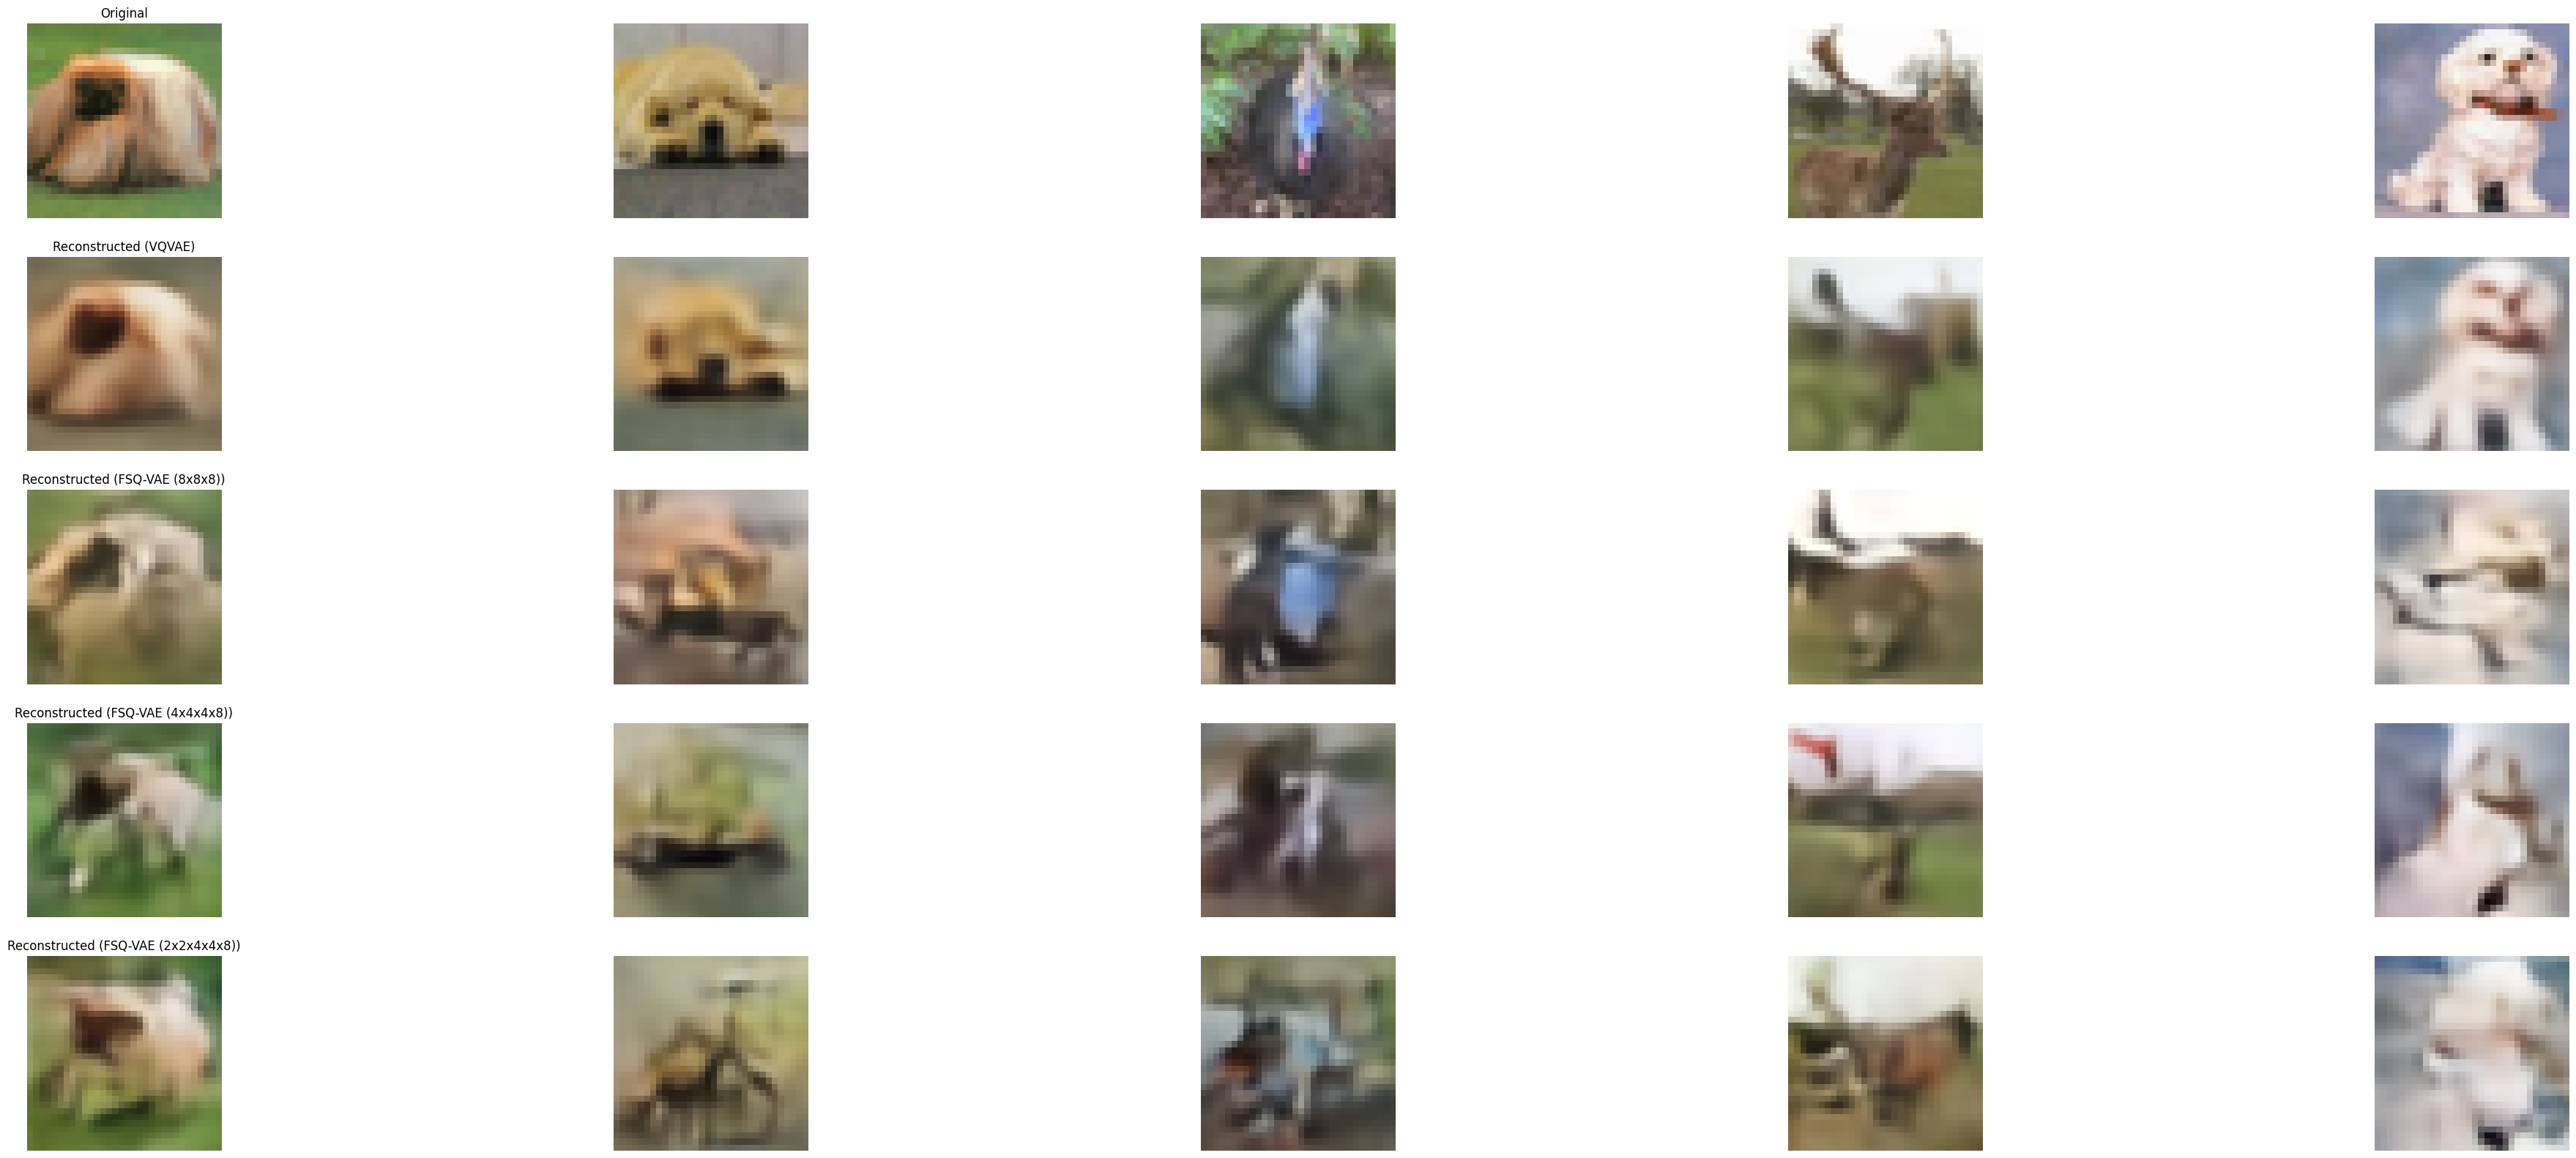

In [47]:
# Plot some reconstructed images
import matplotlib.pyplot as plt

def plot_reconstructions(models: list[VQVAE], model_names: list[str], images: jax.Array):
    num_images = 5
    assert len(models) == len(model_names), "models and model_names must have the same length."

    fig, axes = plt.subplots(len(models) + 1, num_images, figsize=(num_images * 2 * (len(models) + 1), 4 * (len(models) + 1)))

    # Plot original images in the first row
    for j in range(num_images):
        axes[0, j].imshow(images[j].reshape(32, 32, 3), cmap='gray')
        axes[0, j].axis('off')
        if j == 0:
            axes[0, j].set_title("Original")

    for model_idx, model in enumerate(models):
        reconstructed, _ = model(images)
        for j in range(num_images):
            # Reconstructed image
            axes[model_idx + 1, j].imshow(reconstructed[j].reshape(32, 32, 3), cmap='gray')
            axes[model_idx + 1, j].axis('off')
            if j == 0:
                axes[model_idx + 1, j].set_title(f"Reconstructed ({model_names[model_idx]})")
    plt.show()

sample_batch = next(iter(test_grain_dataset))
plot_reconstructions([vqvae, fsqvae, fsqvae2, fsqvae3], ["VQVAE", "FSQ-VAE (8x8x8)", "FSQ-VAE (4x4x4x8)", "FSQ-VAE (2x2x4x4x8)"], sample_batch[:5])

In [48]:
# Convert whole training dataset to indices and display the first image's indices
from array_record.python import array_record_module as arm
import pickle

def export_to_indices(model: VQVAE, train_data: Dataset, output_file: str, batch_size: int = 32):
    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    train_label_grain_dataset = grain.MapDataset.source(train_data) \
        .map(lambda x: {
            "img": preprocess(x["img"]),
            "label": x["label"]
        }) \
        .map(lambda x: {
            "img": x["img"],
            "img_indices": model.encode_to_indices(x["img"].reshape(1, 32, 32, 3)),
            "label": x["label"]
        }) \
        .batch(batch_size=batch_size)

    ar_writer = arm.ArrayRecordWriter(output_file, group_size=256)
    record_count = 0


    with tqdm(
        desc=f"Converting training dataset to indices ",
        total=len(train_data),
        bar_format=BAR_FORMAT,
        leave=True,
    ) as pbar:
        for record in train_label_grain_dataset:
            ar_writer.write(pickle.dumps(record))
            record_count += len(record["img"])
            pbar.update(len(record["img"]))

    ar_writer.close()


In [49]:
export_to_indices(vqvae, train_data, './data/train_vqvae_indices.ar', batch_size=32)

Converting training dataset to indices [1024/50000] [00:29<23:41] 


KeyboardInterrupt: 

In [ ]:
export_to_indices(fsqvae, train_data, './data/train_fsqvae_indices.ar', batch_size=32)

Converting training dataset to indices [0/50000] [00:01<?]


NotImplementedError: encode_to_idx is not implemented for FiniteScalarQuantizer.